In [101]:
import os
import numpy as np
from tqdm import tqdm

import torch

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_theme()
sns.set_palette("Dark2", n_colors=8)

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.utils.metrics import accuracy, nll

os.makedirs(PLOTS_PATH, exist_ok=True)

In [102]:
seed = 42

methods = ["DE", "LA", "MCD"]
dataset_names = ["cifar10", "cifar100", "svhn", "tin"]
n_classes = [10, 100, 10, 200]
models = ["resnet18", "densenet169", "regnet"]
model_names = ["ResNet-18", "DenseNet-169", "RegNet-Y"]

configurations = {
    methods[0]: [models[0]],
    methods[1]: [models[0]],
    methods[2]: [models[0]]
}

p_drop = 0.2                                # dropout rate of MC dropout     
runs = 5                                    # number of runs
eps = 1e-9                                  # epsilon for numerical stability

In [103]:
def get_accs_and_nlls(configurations):

    mean_accuracies, accuracies = dict(), dict()
    mean_nlls, nlls = dict(), dict()

    for method, models_ in tqdm(configurations.items()):
        for model in models_:
            mean_accuracies[method + model], mean_nlls[method + model] = dict(), dict()
            accuracies[method + model], nlls[method + model] = dict(), dict()
            for dataset_name, n_class in zip(dataset_names, n_classes):
                mean_accuracies[method + model][dataset_name],  mean_nlls[method + model][dataset_name] = list(), list()
                accuracies[method + model][dataset_name], nlls[method + model][dataset_name] = list(), list()
                if method == "DE":
                    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
                elif method == "LA":
                    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
                elif method == "MCD":
                    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

                probits = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
                print(method, probits.shape)
                probits = probits.reshape(len(probits), -1, n_class)
                y_test = torch.load(os.path.join(path, f"{dataset_name}_ys.pt"))

                for i in range(probits.shape[1]):
                    accuracies[method + model][dataset_name].append(accuracy(probits[:, i].argmax(dim=-1), y_test))
                    nlls[method + model][dataset_name].append(nll(probits[:, i], y_test, eps))

                probits = probits.reshape(len(probits), runs, -1, n_class)
                probits = probits.mean(dim=2)
                for i in range(probits.shape[1]):
                    mean_accuracies[method + model][dataset_name].append(accuracy(probits[:, i].argmax(dim=-1), y_test))
                    mean_nlls[method + model][dataset_name].append(nll(probits[:, i], y_test, eps))
    return mean_accuracies, accuracies, mean_nlls, nlls

mean_accuracies, accuracies, mean_nlls, nlls = get_accs_and_nlls(configurations)

  0%|          | 0/3 [00:00<?, ?it/s]

DE torch.Size([10000, 50, 10])
DE torch.Size([10000, 50, 100])
DE torch.Size([26032, 50, 10])


 33%|███▎      | 1/3 [00:00<00:00,  2.07it/s]

DE torch.Size([10000, 50, 200])
LA torch.Size([10000, 5, 10, 10])
LA torch.Size([10000, 5, 10, 100])
LA torch.Size([26032, 5, 10, 10])


 67%|██████▋   | 2/3 [00:00<00:00,  2.05it/s]

LA torch.Size([10000, 5, 10, 200])
MCD torch.Size([10000, 5, 10, 10])
MCD torch.Size([10000, 5, 10, 100])
MCD torch.Size([26032, 5, 10, 10])


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

MCD torch.Size([10000, 5, 10, 200])


In [104]:
# create handles for the legend
handle_1 = mlines.Line2D([], [], color='black', marker='.', linestyle='None', label='Single model')
handle_2 = mlines.Line2D([], [], color='black', marker='_', linestyle='None', label='Posterior samples')
handle_3 = mlines.Line2D([], [], color='black', marker='*', linestyle='None', label='Average model')

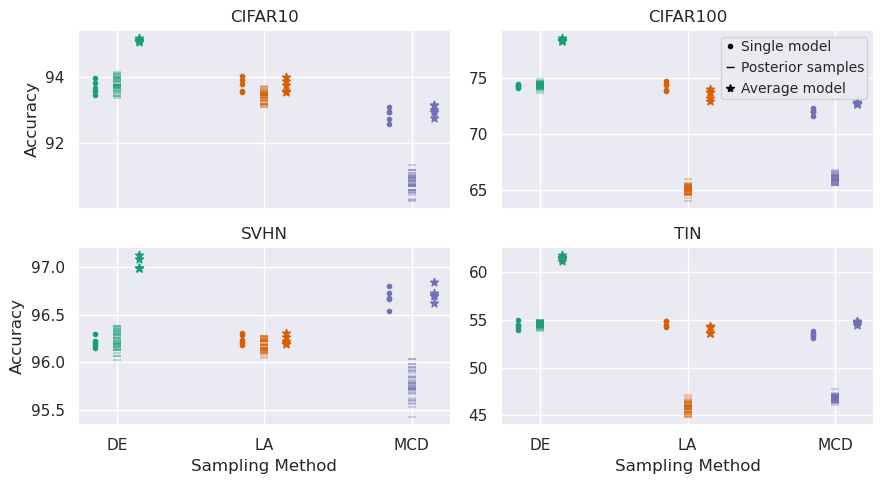

In [105]:
# four subplots for each dataset
fig, axs = plt.subplots(2, 2, figsize=(9, 5), sharex=True)
axs = axs.flatten()

for i, dataset_name in enumerate(dataset_names):
    ax = axs[i]
    j = 0
    for method, models_ in configurations.items():
        for model in models_:
            accs = accuracies[method + model][dataset_name]
            m_accs = mean_accuracies[method + model][dataset_name]
            
            ax.scatter([j - 0.15] * runs, np.asarray(accs).reshape(runs, -1)[:, 0] * 100, 
                       label=f"{method} {model}", color=f"C{j}", marker=".")
            ax.scatter([j] * (len(accs) - runs), np.asarray(accs).reshape(runs, -1)[:, 1:].ravel() * 100, 
                       color=f"C{j}", alpha=0.3, marker="_")
            ax.scatter([j + 0.15] * runs, np.asarray(m_accs) * 100, color=f"C{j}", marker="*")
            j += 1

    ax.set_title(dataset_name.upper())
    if i % 2 == 0: ax.set_ylabel("Accuracy")
    if i // 2 == 1: ax.set_xticks(range(j), [f"{method}" for method in configurations.keys() for model in configurations[method]])
    if i // 2 == 1: ax.set_xlabel("Sampling Method")
    

axs[1].legend(handles=[handle_1, handle_2, handle_3], loc='upper right', fontsize='small', handletextpad=0.4, handlelength=0.8, borderpad=0.2)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, "accuracy_comparison.pdf"))
plt.show()

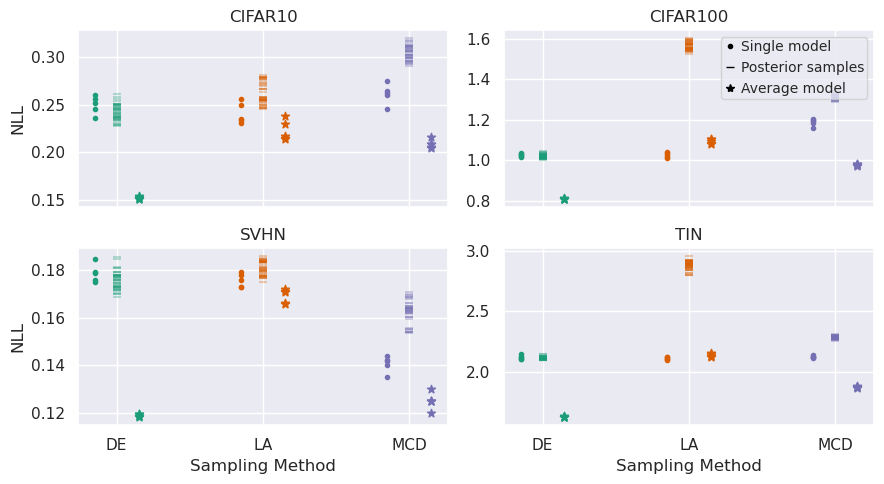

In [106]:
# four subplots for each dataset
fig, axs = plt.subplots(2, 2, figsize=(9, 5), sharex=True)
axs = axs.flatten()

for i, dataset_name in enumerate(dataset_names):
    ax = axs[i]
    j = 0
    for method, models_ in configurations.items():
        for model in models_:
            nlls_ = nlls[method + model][dataset_name]
            m_nlls = mean_nlls[method + model][dataset_name]
            ax.scatter([j - 0.15] * runs, np.asarray(nlls_).reshape(runs, -1)[:, 0], 
                       label=f"{method} {model}", color=f"C{j}", marker=".")
            ax.scatter([j + 0.0] * (len(nlls_) - runs), np.asarray(nlls_).reshape(runs, -1)[:, 1:].ravel(), 
                       color=f"C{j}", alpha=0.3, marker="_")
            ax.scatter([j + 0.15] * runs, np.asarray(m_nlls), color=f"C{j}", marker="*")
            j += 1
    ax.set_title(dataset_name.upper())
    # ax.set_yscale("log")
    if i % 2 == 0: ax.set_ylabel("NLL")
    if i // 2 == 1: ax.set_xticks(range(j), [f"{method}" for method in configurations.keys() for _ in configurations[method]])
    if i // 2 == 1: ax.set_xlabel("Sampling Method")

axs[1].legend(handles=[handle_1, handle_2, handle_3], loc='upper right', fontsize='small', handletextpad=0.4, handlelength=0.8, borderpad=0.2)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, "nll_comparison.pdf"))
plt.show()

In [107]:
configurations = {
    methods[0]: models
}

method = "DE"

mean_accuracies, accuracies, mean_nlls, nlls = get_accs_and_nlls(configurations)

  0%|          | 0/1 [00:00<?, ?it/s]

DE torch.Size([10000, 50, 10])
DE torch.Size([10000, 50, 100])
DE torch.Size([26032, 50, 10])
DE torch.Size([10000, 50, 200])
DE torch.Size([10000, 50, 10])
DE torch.Size([10000, 50, 100])
DE torch.Size([26032, 50, 10])
DE torch.Size([10000, 50, 200])
DE torch.Size([10000, 50, 10])
DE torch.Size([10000, 50, 100])
DE torch.Size([26032, 50, 10])


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

DE torch.Size([10000, 50, 200])


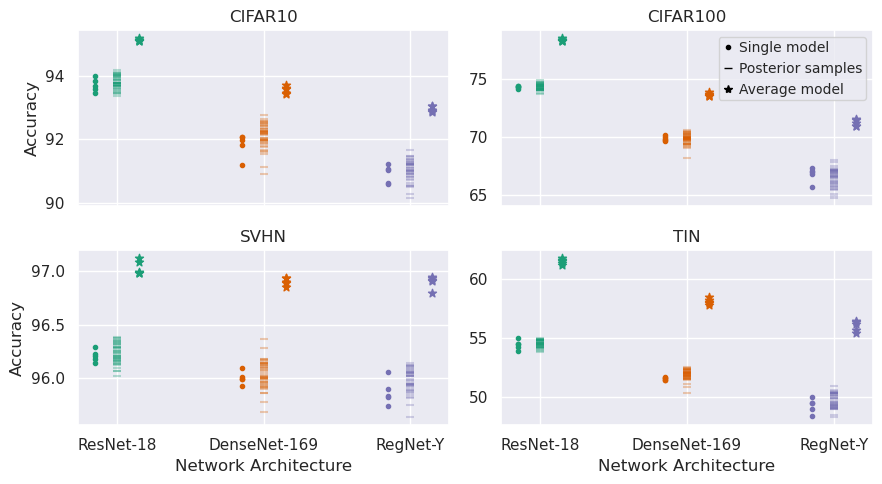

In [108]:
# four subplots for each dataset
fig, axs = plt.subplots(2, 2, figsize=(9, 5), sharex=True)
axs = axs.flatten()


for i, dataset_name in enumerate(dataset_names):
    ax = axs[i]
    j = 0
    for models_ in configurations.values():
        for model in models_:
            accs = accuracies[method + model][dataset_name]
            m_accs = mean_accuracies[method + model][dataset_name]
            
            ax.scatter([j - 0.15] * runs, np.asarray(accs).reshape(runs, -1)[:, 0] * 100, 
                       label=f"{method} {model}", color=f"C{j}", marker=".")
            ax.scatter([j] * (len(accs) - runs), np.asarray(accs).reshape(runs, -1)[:, 1:].ravel() * 100, 
                       color=f"C{j}", alpha=0.3, marker="_")
            ax.scatter([j + 0.15] * runs, np.asarray(m_accs) * 100, color=f"C{j}", marker="*")
            j += 1
    ax.set_title(dataset_name.upper())
    if i % 2 == 0: ax.set_ylabel("Accuracy")
    if i // 2 == 1: ax.set_xticks(range(j), [f"{model_name}" for model_name in model_names])
    if i // 2 == 1: ax.set_xlabel("Network Architecture")
    

axs[1].legend(handles=[handle_1, handle_2, handle_3], loc='upper right', fontsize='small', handletextpad=0.4, handlelength=0.8, borderpad=0.25)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, "accuracy_comparison_network.pdf"))
plt.show()

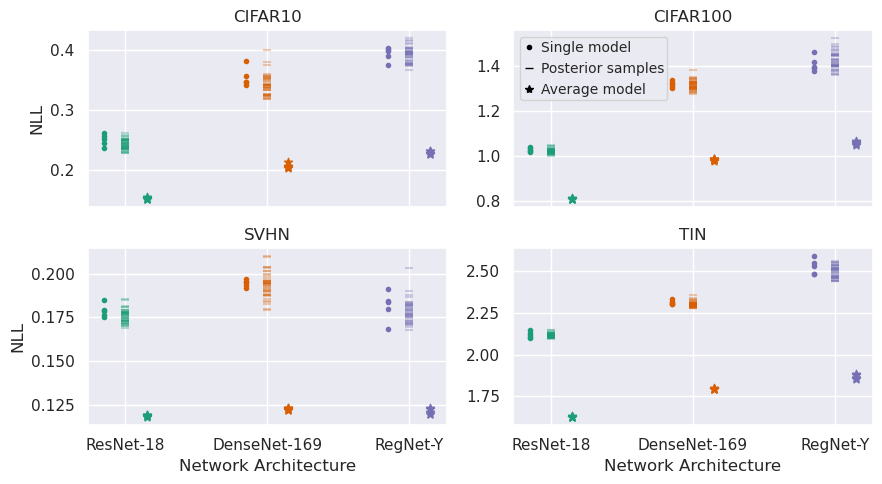

In [109]:
# four subplots for each dataset
fig, axs = plt.subplots(2, 2, figsize=(9, 5), sharex=True)
axs = axs.flatten()

for i, dataset_name in enumerate(dataset_names):
    ax = axs[i]
    j = 0
    for method, models_ in configurations.items():
        for model in models_:
            nlls_ = nlls[method + model][dataset_name]
            m_nlls = mean_nlls[method + model][dataset_name]
            ax.scatter([j - 0.15] * runs, np.asarray(nlls_).reshape(runs, -1)[:, 0], 
                       label=f"{method} {model}", color=f"C{j}", marker=".")
            ax.scatter([j + 0.0] * (len(nlls_) - runs), np.asarray(nlls_).reshape(runs, -1)[:, 1:].ravel(), 
                       color=f"C{j}", alpha=0.3, marker="_")
            ax.scatter([j + 0.15] * runs, np.asarray(m_nlls), color=f"C{j}", marker="*")
            j += 1
    ax.set_title(dataset_name.upper())
    # ax.set_yscale("log")
    if i % 2 == 0: ax.set_ylabel("NLL")
    if i // 2 == 1: ax.set_xticks(range(j), [f"{model_name}" for model_name in model_names])
    if i // 2 == 1: ax.set_xlabel("Network Architecture")

axs[1].legend(handles=[handle_1, handle_2, handle_3], loc='upper left', fontsize='small', handletextpad=0.4, handlelength=0.8, borderpad=0.25)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, "nll_comparison_network.pdf"))
plt.show()